 # Getting the Data

In [1]:
import os.path
raw_documents = []
snippets = []

with open( os.path.join("uploads", "master_race.txt") ,"r") as fin:
    for line in fin.readlines():
        text = line.strip()
        raw_documents.append( text )
        # keep a short snippet of up to 100 characters as a title for each article
        snippets.append( text[0:min(len(text),100)] )
print("Read %d raw text documents" % len(raw_documents))

Read 832 raw text documents


In [2]:
custom_stop_words = []
with open( "stopwords.txt", "r" ) as fin:
    for line in fin.readlines():
        custom_stop_words.append( line.strip() )
# note that we need to make it hashable
print("Stopword list has %d entries" % len(custom_stop_words) )

Stopword list has 350 entries


In [3]:
from sklearn.feature_extraction.text import CountVectorizer
# use a custom stopwords list, set the minimum term-document frequency to 20
vectorizer = CountVectorizer(stop_words = custom_stop_words, min_df = 20)
A = vectorizer.fit_transform(raw_documents)
print( "Created %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )

Created 832 X 10 document-term matrix


In [16]:
terms = vectorizer.get_feature_names()
print("Vocabulary has %d distinct terms" % len(terms))

Vocabulary has 10 distinct terms


In [17]:
import joblib
joblib.dump((A,terms,snippets), "articles-raw.pkl")

['articles-raw.pkl']

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
# we can pass in the same preprocessing parameters
vectorizer = TfidfVectorizer(stop_words=custom_stop_words, min_df = 20)
A = vectorizer.fit_transform(raw_documents)
print( "Created %d X %d TF-IDF-normalized document-term matrix" % (A.shape[0], A.shape[1]) )

Created 832 X 10 TF-IDF-normalized document-term matrix


In [19]:
# extract the resulting vocabulary
terms = vectorizer.get_feature_names()
print("Vocabulary has %d distinct terms" % len(terms))

Vocabulary has 10 distinct terms


In [20]:

import operator
def rank_terms( A, terms ):
    # get the sums over each column
    sums = A.sum(axis=0)
    # map weights to the terms
    weights = {}
    for col, term in enumerate(terms):
        weights[term] = sums[0,col]
    # rank the terms by their weight over all documents
    return sorted(weights.items(), key=operator.itemgetter(1), reverse=True)

In [21]:
ranking = rank_terms( A, terms )
for i, pair in enumerate( ranking[0:20] ):
    print( "%02d. %s (%.2f)" % ( i+1, pair[0], pair[1] ) )

01. gutenberg (55.11)
02. project (51.41)
03. work (30.58)
04. tm (30.13)
05. foundation (22.10)
06. works (20.15)
07. law (18.18)
08. terms (17.93)
09. copyright (17.33)
10. electronic (15.50)


In [22]:
joblib.dump((A,terms,snippets), "articles-tfidf.pkl")

['articles-tfidf.pkl']

In [25]:
(A,terms,snippets) = joblib.load( "articles-tfidf.pkl")
print( "Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )

Loaded 832 X 10 document-term matrix


In [26]:
# The key input parameter to NMF is the number of topics to generate k. For the moment, we will pre-specify a guessed value, for demonstration purposes.
k=10

In [27]:

# create the model
from sklearn import decomposition
model = decomposition.NMF( init="nndsvd", n_components=k ) 
# apply the model and extract the two factor matrices
W = model.fit_transform( A )
H = model.components_

In [28]:
W.shape

(832, 10)

In [29]:
W[0,:].round(2)

array([0.26, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.31, 0.  , 0.  ])

In [30]:

H.shape

(10, 10)

In [32]:
terms

['copyright',
 'electronic',
 'foundation',
 'gutenberg',
 'law',
 'project',
 'terms',
 'tm',
 'work',
 'works']

In [33]:
term_index = terms.index('law')
# round to 2 decimal places for display purposes
H[:,term_index].round(2)

array([0.  , 0.  , 0.  , 2.15, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

In [34]:

import numpy as np
def get_descriptor( terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
    return top_terms

In [35]:

descriptors = []
for topic_index in range(k):
    descriptors.append( get_descriptor( terms, H, topic_index, 10 ) )
    str_descriptor = ", ".join( descriptors[topic_index] )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: gutenberg, tm, works, work, terms, project, law, foundation, electronic, copyright
Topic 02: work, electronic, works, tm, terms, project, law, gutenberg, foundation, copyright
Topic 03: foundation, project, gutenberg, works, work, tm, terms, law, electronic, copyright
Topic 04: law, works, copyright, work, project, tm, terms, gutenberg, foundation, electronic
Topic 05: works, tm, copyright, work, terms, project, law, gutenberg, foundation, electronic
Topic 06: terms, tm, work, works, project, law, gutenberg, foundation, electronic, copyright
Topic 07: copyright, works, terms, foundation, work, tm, project, law, gutenberg, electronic
Topic 08: project, gutenberg, works, terms, work, tm, law, foundation, electronic, copyright
Topic 09: tm, project, gutenberg, work, works, terms, law, foundation, electronic, copyright
Topic 10: electronic, tm, work, works, terms, project, law, gutenberg, foundation, copyright


In [36]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

In [37]:
def plot_top_term_weights( terms, H, topic_index, top ):
    # get the top terms and their weights
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    top_terms = []
    top_weights = []
    for term_index in top_indices[0:top]:
        top_terms.append( terms[term_index] )
        top_weights.append( H[topic_index,term_index] )
    # note we reverse the ordering for the plot
    top_terms.reverse()
    top_weights.reverse()
    # create the plot
    fig = plt.figure(figsize=(13,8))
    # add the horizontal bar chart
    ypos = np.arange(top)
    ax = plt.barh(ypos, top_weights, align="center", color="green",tick_label=top_terms)
    plt.xlabel("Term Weight",fontsize=14)
    plt.tight_layout()
    plt.show()

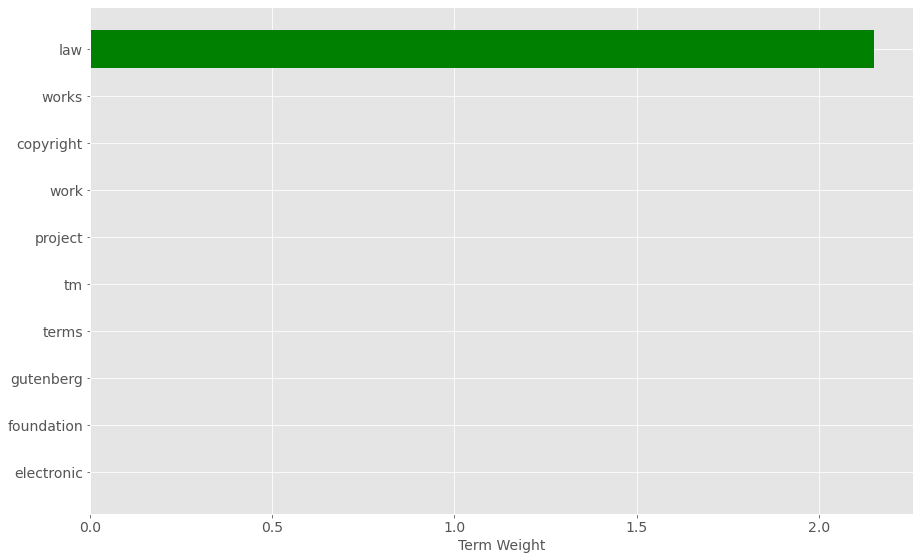

In [44]:
plot_top_term_weights( terms, H, 3, 10 )

In [45]:
def get_top_snippets( all_snippets, W, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( W[:,topic_index] )[::-1]
    # now get the snippets corresponding to the top-ranked indices
    top_snippets = []
    for doc_index in top_indices[0:top]:
        top_snippets.append( all_snippets[doc_index] )
    return top_snippets
    

In [46]:
topic_snippets = get_top_snippets( snippets, W, 0, 10 )
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ( (i+1), snippet ) )

01. donate, please visit: www.gutenberg.org/donate
02. eBook or online at www.gutenberg.org. If you are not located in the
03. facility: www.gutenberg.org
04. Gutenberg eBooks may be modified and printed and given away--you may
05. state visit www.gutenberg.org/donate
06. www.gutenberg.org/license.
07. www.gutenberg.org. If you are not located in the United States, you
08. (www.gutenberg.org), you must, at no additional cost, fee or expense
09. and official page at www.gutenberg.org/contact
10. www.gutenberg.org


In [47]:
topic_snippets = get_top_snippets( snippets, W, 1, 10 )
for i, snippet in enumerate(topic_snippets):
    print("%02d. %s" % ( (i+1), snippet ) )

01. in paragraph 1.F.3, this work is provided to you 'AS-IS', WITH NO
02. with the defective work may elect to provide a replacement copy in
03. any money paid for a work or a replacement copy, if a defect in the
04. receipt of the work.
05. of obtaining a copy upon request, of the work in its original "Plain
06. PLEASE READ THIS BEFORE YOU DISTRIBUTE OR USE THIS WORK
07. written explanation to the person you received the work from. If you
08. received the work on a physical medium, you must return the medium
09. 1.E.6. You may convert to and distribute this work in any binary,
10. beginning of this work.


In [48]:
joblib.dump((W,H,terms,snippets), "articles-model-nmf-k%02d.pkl" % k)

['articles-model-nmf-k10.pkl']

In [49]:
(A,terms,snippets) = joblib.load( "articles-tfidf.pkl" )
print( "Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]) )

Loaded 832 X 10 document-term matrix


In [50]:
kmin, kmax = 4, 9

In [51]:
from sklearn import decomposition
topic_models = []
# try each value of k
for k in range(kmin,kmax+1):
    print("Applying NMF for k=%d ..." % k )
    # run NMF
    model = decomposition.NMF( init="nndsvd", n_components=k ) 
    W = model.fit_transform( A )
    H = model.components_    
    # store for later
    topic_models.append( (k,W,H) )

Applying NMF for k=4 ...
Applying NMF for k=5 ...
Applying NMF for k=6 ...
Applying NMF for k=7 ...
Applying NMF for k=8 ...
Applying NMF for k=9 ...


In [53]:
import os.path
raw_documents = []
with open( os.path.join("uploads", "master_race.txt") ,"r") as fin:
    for line in fin.readlines():
        raw_documents.append( line.strip().lower() )
print("Read %d raw text documents" % len(raw_documents))

Read 832 raw text documents


In [54]:
custom_stop_words = []
with open( "stopwords.txt", "r" ) as fin:
    for line in fin.readlines():
        custom_stop_words.append( line.strip().lower() )
# note that we need to make it hashable
print("Stopword list has %d entries" % len(custom_stop_words) )

Stopword list has 350 entries


In [55]:
import re
class TokenGenerator:
    def __init__( self, documents, stopwords ):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__( self ):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 2:
                    tokens.append( tok )
            yield tokens

In [56]:
import gensim
docgen = TokenGenerator( raw_documents, custom_stop_words )
# the model has 500 dimensions, the minimum document-term frequency is 20
w2v_model = gensim.models.Word2Vec(docgen, size=500, min_count=20, sg=1)

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...


In [57]:
print( "Model has %d terms" % len(w2v_model.wv.vocab) )

Model has 11 terms


In [58]:
w2v_model.save("w2v-model.bin")

In [59]:
# To re-load this model, run
#w2v_model = gensim.models.Word2Vec.load("w2v-model.bin")

In [60]:
def calculate_coherence( w2v_model, term_rankings ):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

In [61]:

import numpy as np
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

In [62]:
from itertools import combinations
k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=04: Coherence=0.9686
K=05: Coherence=0.9686
K=06: Coherence=0.9686
K=07: Coherence=0.9686
K=08: Coherence=0.9686
K=09: Coherence=0.9686
<ipython-input-60-c8fae5ea8823>:7: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  pair_scores.append( w2v_model.similarity(pair[0], pair[1]) )


In [63]:
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

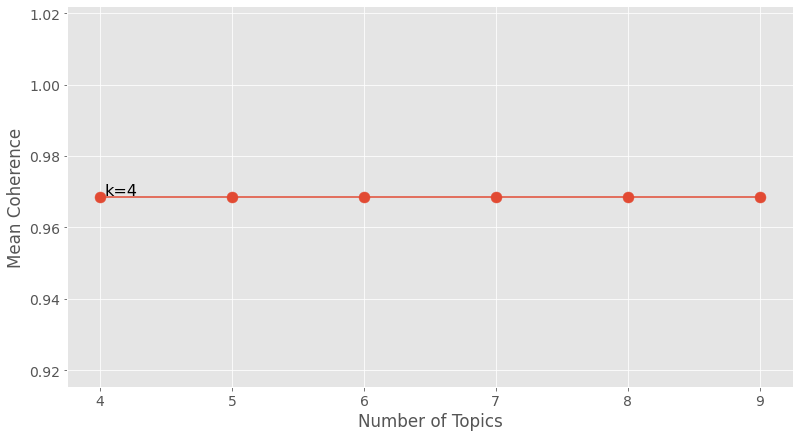

In [64]:
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter( k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

In [65]:
k = best_k
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

In [66]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10 )
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: gutenberg, project, tm, works, electronic, terms, work, law, foundation, copyright
Topic 02: work, electronic, works, terms, tm, copyright, project, law, gutenberg, foundation
Topic 03: foundation, gutenberg, copyright, work, works, tm, terms, project, law, electronic
Topic 04: law, copyright, works, project, terms, work, tm, gutenberg, foundation, electronic
